<a href="https://colab.research.google.com/github/vchandraiitk/datascience/blob/main/M8_NB_MiniProject_4_AirQuality_Forecast_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Air quality forecasting using ARIMA

## Learning Objectives

At the end of the experiment, you will be able to :

* perform EDA on time series data
* analyze the auto correlation and partial auto correlation plots
* implement the ARIMA model and forecast the air quality

## Information

ARIMA stands for auto-regressive integrated moving average. It’s a way of modelling time series data for forecasting (i.e., for predicting future points in the series), in such a way that:

* a pattern of growth/decline in the data is accounted for (“auto-regressive” part)
* the rate of change of the growth/decline in the data is accounted for (the “integrated” part)
* noise between consecutive time points is accounted for (the “moving average” part)

ARIMA models are typically expressed like “ARIMA(p,d,q)”, with the three terms p, d, and q defined as follows:

* p means the number of preceding (“lagged”) Y values that have to be added/subtracted to Y in the model, so as to make better predictions based on local periods of growth/decline in our data. This captures the “autoregressive” nature of ARIMA.

* d represents the number of times that the data have to be “differenced” to produce a stationary signal (i.e., a signal that has a constant mean over time). This captures the “integrated” nature of ARIMA. If d=0, this means that our data does not tend to go up/down in the long term (i.e., the model is already “stationary”). In this case, then technically you are performing just ARMA, not AR-I-MA. If p is 1, then it means that the data is going up/down linearly. If p is 2, then it means that the data is going up/down exponentially. More on this below…

* q represents the number of preceding/lagged values for the error term that are added/subtracted to Y. This captures the “moving average” part of ARIMA.



Refer to the basics of Air quality index [here](https://www.airnow.gov/aqi/aqi-basics/)

## Dataset



This dataset includes hourly air pollutants data from 12 nationally-controlled air-quality monitoring sites. The air-quality data are from the Beijing Municipal Environmental Monitoring Center. The meteorological data in each air-quality site are matched with the nearest weather station from the China Meteorological Administration. The time period is from March 1st, 2013 to February 28th, 2017. Missing data are denoted as NA.

**Attributes Information:**

* No: row number
* year: year of data in this row
* month: month of data in this row
* day: day of data in this row
* hour: hour of data in this row
* PM2.5: PM2.5 concentration (ug/m^3)

  Fine particulate matter (PM2.5) is an air pollutant that is a concern for people's health when levels in air are high. PM2.5 are tiny particles in the air that reduce visibility and cause the air to appear hazy when levels are elevated

* PM10: PM10 concentration (ug/m^3)
* SO2: SO2 concentration (ug/m^3)
* NO2: NO2 concentration (ug/m^3)
* CO: CO concentration (ug/m^3)
* O3: O3 concentration (ug/m^3)
* TEMP: temperature (degree Celsius)
* PRES: pressure (hPa)
* DEWP: dew point temperature (degree Celsius)
* RAIN: precipitation (mm)
* wd: wind direction
* WSPM: wind speed (m/s)
* station: name of the air-quality monitoring site

**Dataset source:** https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data

## Problem Statement

Implement ARIMA model to forecast the air quality using Beijing air quality dataset

## Grading = 10 Points

In [1]:
#@title Download Dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/PRSA_Data_Nongzhanguan_20130301_20170228.csv
print("Dataset downloaded successfully!!")

Dataset downloaded successfully!!


### Import required Packages

In [2]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import expit, logit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import itertools

### Load the data and analyze (2 Points)

Refer to casestudy: [M6_NB_Case_Study_EDA_Air_Quality_Data](https://drive.google.com/file/d/1BL6vbcSH9HEhH20zvnABTjoSaZ-a4olg/view?usp=drive_link)

In [12]:
path = "PRSA_Data_Nongzhanguan_20130301_20170228.csv"
# YOUR CODE HERE
df = pd.read_csv(path)
df.head(5)

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Nongzhanguan
1,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,84.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Nongzhanguan
2,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,83.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Nongzhanguan
3,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,84.0,-1.4,1026.2,-25.5,0.0,N,4.9,Nongzhanguan
4,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,77.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Nongzhanguan


### Correlation plot between Features (1 Point)

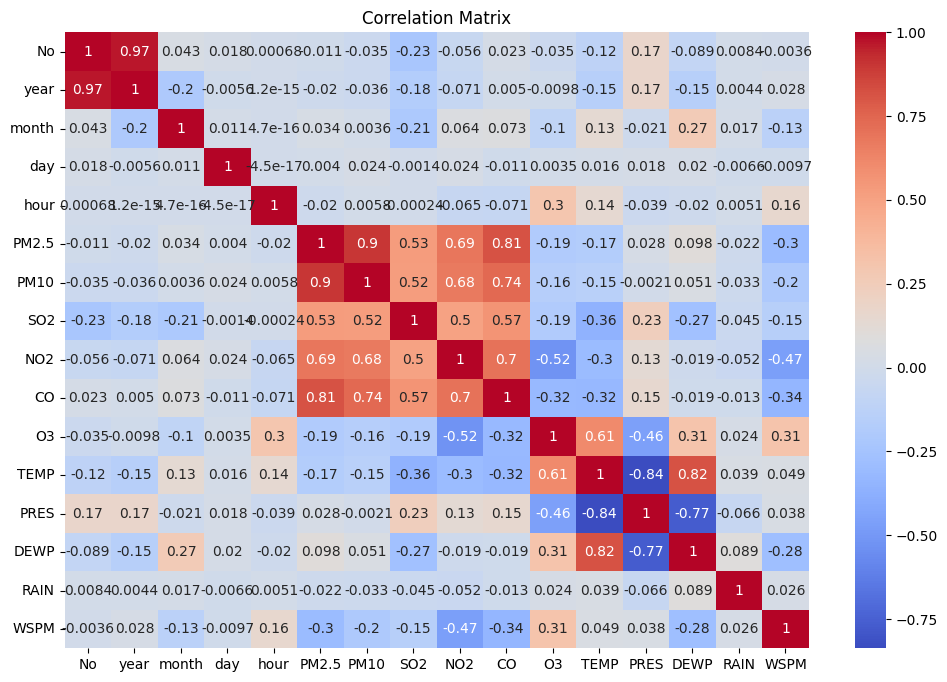

In [4]:
# YOUR CODE HERE
correlation_matrix = df.corr(numeric_only=True)

# Set the figure size before creating the heatmap
plt.figure(figsize=(12, 8))  # Adjust width (12) and height (8) as needed

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Identify the trends and seasonality from the given time series data (1 Point)

Hint: `seasonal_decompose()`

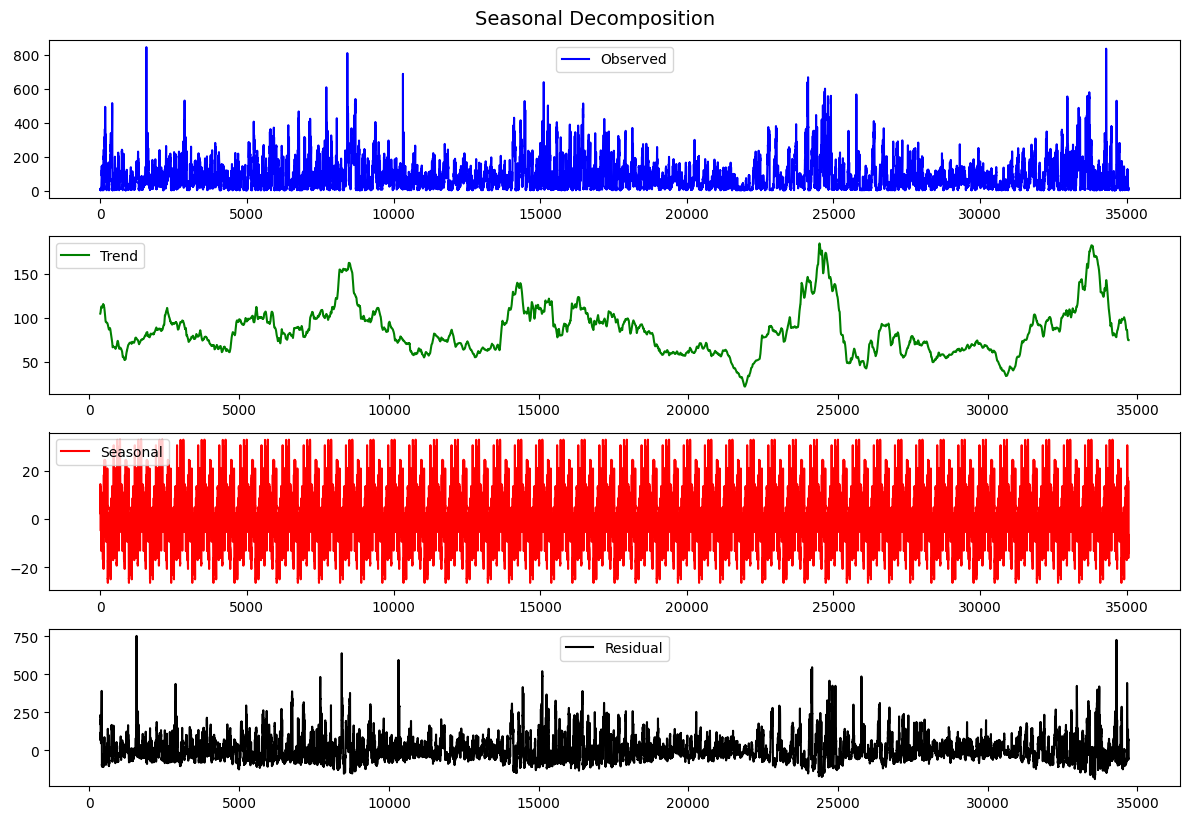

In [17]:
# YOUR CODE HERE
# Handle missing values by filling with the previous valid value (forward fill)
#I was getting error without this step
df['PM2.5'] = df['PM2.5'].fillna(method='ffill')

# Perform seasonal decomposition on the 'PM2.5' price with an additive model

decomposition = seasonal_decompose(df['PM2.5'], model='additive', period=24*30)

# Plot the decomposition results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed', color='blue')
plt.legend(loc='best')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend(loc='best')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal', color='red')
plt.legend(loc='best')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual', color='black')
plt.legend(loc='best')

plt.tight_layout()
plt.suptitle("Seasonal Decomposition", fontsize=14, y=1.02)
plt.show()

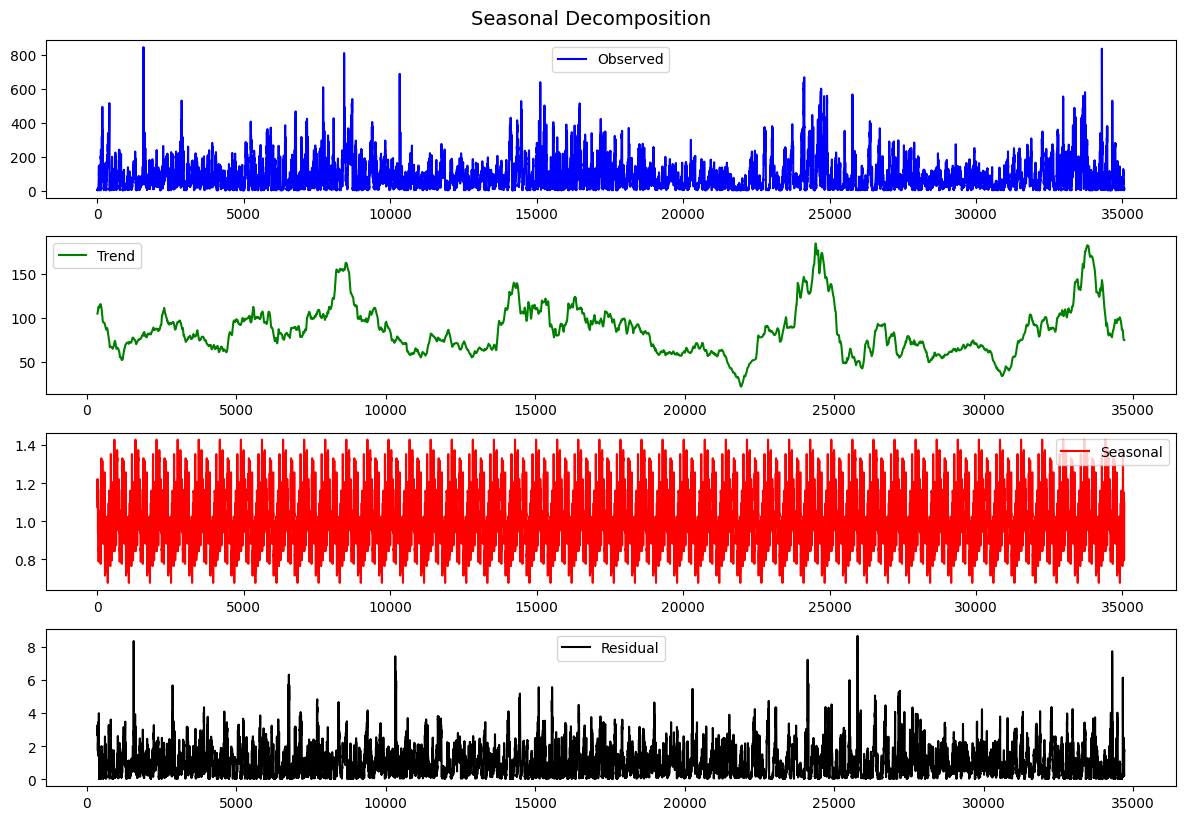

In [18]:
# YOUR CODE HERE
# Handle missing values by filling with the previous valid value (forward fill)
#I was getting error without this step
# Perform seasonal decomposition on the 'PM2.5' price with an additive model

decomposition = seasonal_decompose(df['PM2.5'], model='multiplicative', period=24*30)

# Plot the decomposition results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed', color='blue')
plt.legend(loc='best')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend(loc='best')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal', color='red')
plt.legend(loc='best')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual', color='black')
plt.legend(loc='best')

plt.tight_layout()
plt.suptitle("Seasonal Decomposition", fontsize=14, y=1.02)
plt.show()

### Time Series Stationarity (2 Points)

Check the Stationarity of time series using:
  * Dickey Fuller test
  * Rolling mean and Rolling standard deviation

Make the timeseries stationary

* Apply Log transformation and **Differencing** of the timeseries to make it stationary

Verify the stationarity with the Dickey Fuller test

### Dickey Fuller test

In [19]:
# YOUR CODE HERE
df_cleaned = df.copy()
df_cleaned['PM2.5'] = df_cleaned['PM2.5'].diff().dropna()

# Perform ADF test again on the differenced series
adf_result_diff = adfuller(df_cleaned['PM2.5'].dropna())

# Extract results
adf_output_diff = {
    "ADF Statistic": adf_result_diff[0],
    "p-value": adf_result_diff[1],
    "Critical Values": adf_result_diff[4]
}

# Display ADF test results for differenced series
adf_output_diff

{'ADF Statistic': -34.15004208275884,
 'p-value': 0.0,
 'Critical Values': {'1%': -3.43053679213716,
  '5%': -2.8616225575095284,
  '10%': -2.566813942767471}}

Since the **ADF Statistic is far lower than the critical values** and the **p-value is close to zero**, we **reject the null hypothesis and conclude that the time series is stationary**.

### Rolling mean and Rolling standard deviation

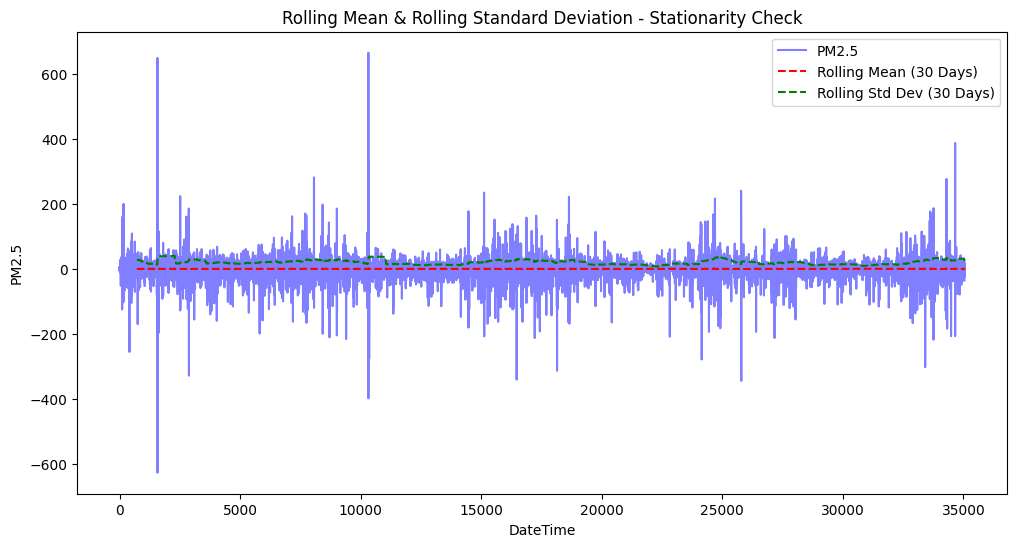

In [21]:
window_size = 24*30  # 30-day rolling window
rolling_mean = df_cleaned['PM2.5'].rolling(window=window_size).mean()
rolling_std = df_cleaned['PM2.5'].rolling(window=window_size).std()

# Plot rolling mean and rolling standard deviation
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned['PM2.5'], label='PM2.5', color='blue', alpha=0.5)
plt.plot(rolling_mean, label='Rolling Mean (30 Days)', color='red', linestyle='dashed')
plt.plot(rolling_std, label='Rolling Std Dev (30 Days)', color='green', linestyle='dashed')

plt.title('Rolling Mean & Rolling Standard Deviation - Stationarity Check')
plt.xlabel('DateTime')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

## Make the timeseries stationary

#### Apply Log transformation and Differencing of the timeseries to make it stationary
#### Verify the stationarity with the Dickey Fuller test

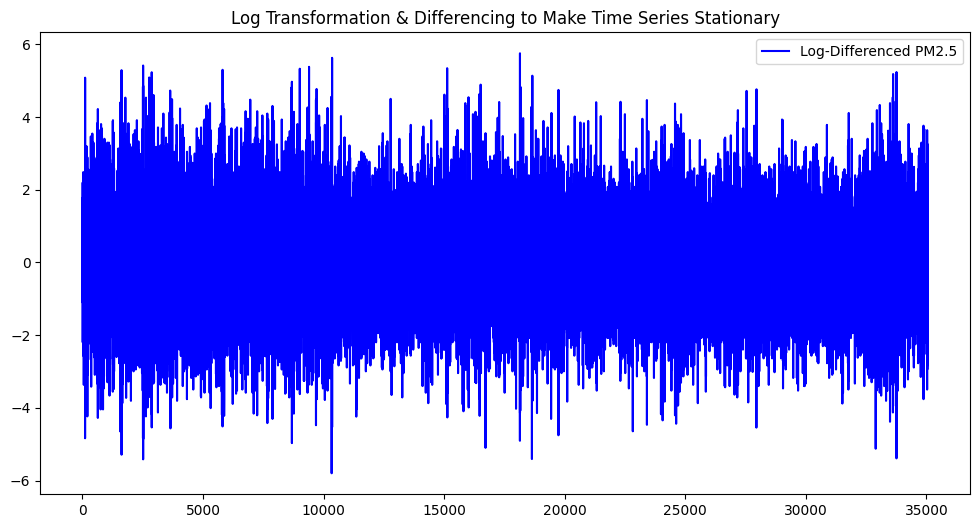

{'Test Statistic': -38.738094618254266,
 'p-value': 0.0,
 'Lags Used': 52,
 'Number of Observations': 35009,
 'Critical Values': {'1%': -3.4305368028090353,
  '5%': -2.861622562226085,
  '10%': -2.5668139452779717}}

In [28]:
# Step 1: Apply Log Transformation to Reduce Variance
df_cleaned['PM2.5'] = pd.to_numeric(df_cleaned['PM2.5'], errors='coerce')

# Drop rows with NaN values in 'PM2.5' resulting from coercion (if any)
df_cleaned = df_cleaned.dropna(subset=['PM2.5'])

# Impute missing values before applying the log transformation
# (You can choose an appropriate imputation method like mean, median, or forward fill)
df_cleaned['PM2.5'] = df_cleaned['PM2.5'].fillna(df_cleaned['PM2.5'].mean()) # Using mean for imputation

# Ensure all values are positive before applying log transformation
df_cleaned['PM2.5'] = df_cleaned['PM2.5'].abs() + 1  # Add 1 to make all values positive

# Calculate log transformation on the numeric 'PM2.5' column
df_cleaned['PM2.5_Log'] = np.log(df_cleaned['PM2.5'])

# Apply first-order differencing to remove trends
df_daily_log_diff = df_cleaned[['PM2.5_Log']].diff().dropna()  # Select only 'PM2.5_Log'

# Perform Dickey-Fuller test on transformed data
adf_test_transformed = adfuller(df_daily_log_diff)
# Extract and display results
adf_output_transformed = {
    'Test Statistic': adf_test_transformed[0],
    'p-value': adf_test_transformed[1],
    'Lags Used': adf_test_transformed[2],
    'Number of Observations': adf_test_transformed[3],
    'Critical Values': adf_test_transformed[4]
}

# Plot the transformed series
plt.figure(figsize=(12, 6))
plt.plot(df_daily_log_diff, label="Log-Differenced PM2.5", color="blue")
plt.legend()
plt.title("Log Transformation & Differencing to Make Time Series Stationary")
plt.show()

# Display ADF Test Results after transformation
adf_output_transformed

### Auto Correlation Plot Analysis ( 2 Points)

Autocorrelation refers to the degree of correlation between the values of the same variables across different observations in the data.  The concept of autocorrelation is most often discussed in the context of time series data in which observations occur at different points in time (e.g.,temperature measured on different days of the month, hours of the day).  For example, one might expect the air temperature on the $1^{st}$ day of the month to be more similar to the temperature on the $2^{nd}$ day compared to the $31^{st}$ day.  If the temperature values that occurred closer together in time are, in fact, more similar than the temperature values that occurred farther apart in time, the data would be autocorrelated.

Autocorrelation can cause problems in conventional analyses (such as ordinary least squares regression) that assume independence of observations.

In a regression analysis, autocorrelation of the regression residuals can also occur if the model is incorrectly specified.  For example, if you are attempting to model a simple linear relationship but the observed relationship is non-linear (i.e., it follows a curved or U-shaped function), then the residuals will be autocorrelated.

* Plot ACF and PACF graphs
* Analyse and identify the ARIMA (p, d, q) terms

<Figure size 1200x600 with 0 Axes>

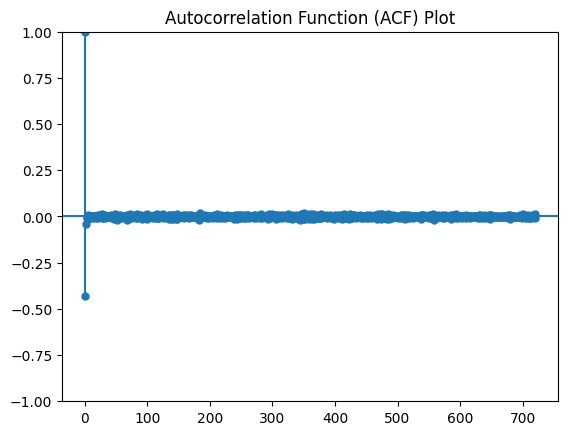

<Figure size 1200x600 with 0 Axes>

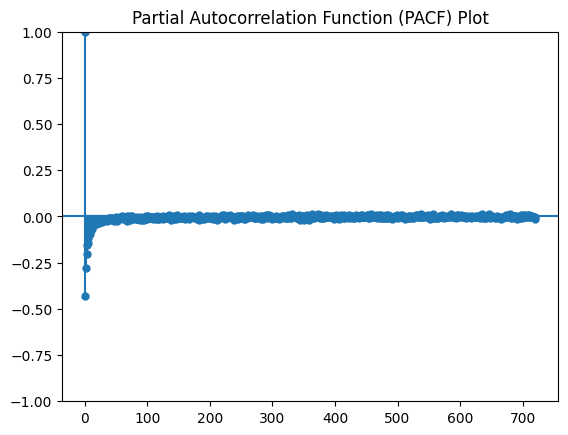

In [30]:
# YOUR CODE HERE
# Plot ACF (AutoCorrelation Function) to determine MA(q) order
plt.figure(figsize=(12, 6))
plot_acf(df_daily_log_diff['PM2.5_Log'], lags=24*30)
plt.title("Autocorrelation Function (ACF) Plot")
plt.show()

# Plot PACF (Partial AutoCorrelation Function) to determine AR(p) order
plt.figure(figsize=(12, 6))
plot_pacf(df_daily_log_diff['PM2.5_Log'], lags=24*30)
plt.title("Partial Autocorrelation Function (PACF) Plot")
plt.show()

### Implement ARIMA model (2 Points)

* Fit the timeseries data with ARIMA
* Find and interpret the loss (AIC)

In [8]:
# YOUR CODE HERE for ARIMA Model

#### Plot the predictions

In [9]:
# YOUR CODE HERE

### Implement SARIMAX model (optional)

A SARIMA model can be tuned with two kinds of orders: (p,d,q) order, which refers to the order of the time series. This order is also used in the ARIMA model (which does not consider seasonality); (P,D,Q,S) seasonal order, which refers to the order of the seasonal component of the time series.

$\color{blue}{\text{Note: Implementing SARIMAX in Colab may crash the session as it may run out of RAM.}}$


$\color{blue}{\text{Alternatively you could use (free) AWS Sagemaker StudioLab. Refer to AWS Sagemaker StudioLab introductory video }}$

$$\href{https://drive.google.com/file/d/13cEzQvTzngnF8ytmHEKxUtBk72d_PqQN/view?usp=drive_link}{Click Here}$$


In [10]:
# Fit the SARIMA model
# YOUR CODE HERE

#### Plot the predictions

In [11]:
# predicting with SARIMA
# YOUR CODE HERE

### Report Analysis

* Comment on the trend and seasonality of the time series data
* Comment on results of the Dickey Fuller test analysis
* Is the air quality becoming poorer across the years?
* Do we see spikes indicating poor air quality in particular periods each year? What could be the reasons?

For related reading, refer to: [Time Series Analysis of PM 2.5 in Beijing](https://ionides.github.io/531w20/midterm_project/project11/midterm-project.html)